# ResNet(50)
----

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import joblib
import math
import random

/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Utility Functions
-----

In [4]:
def img_resize(X_data, new_height, new_width, rgb= True):

    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

In [5]:
def get_letter_img (letter):
  X_new = img_resize(X, 32, 32)
  letter_idx = alphabet.index(letter.lower())
  letter_image = tf.reshape(X_new[0], shape=(32, 32, 3))
  return letter_image

In [6]:
def get_conv_layer_ouput(model, layer_name, input_img):

  # force input_img shape to match model input shape
  input_img = tf.reshape(input_img, shape=(-1,32, 32, 3))

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)
  output_conv = conv_model.predict(input_img)

  num_filters = output_conv.shape[-1]
  #output_conv[0,:,:,0] ->  results of first feature map when passed over the first filter

  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))
  ax = axes.flatten()


  for i in range(num_filters):
    ax[i].imshow(output_conv[0,:,:,i], cmap='viridis')
    ax[i].set_title(f'Filter {i+1} Output', fontsize = '20')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()

In [7]:
def inspect_weights(model, layer_name):
  '''
    Overview:
    To get weights from a given layer.

    Arguments:
        - model: CNN model to inspect
        - layer_name: name of layer to access weights

    Output:
        - kernels (weights) as a 3x3 image
  '''
  layer = model.get_layer(layer_name)
  weights, baises = layer.get_weights()

  num_filters = weights.shape[-1]
  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))

  for i, ax in enumerate(axes.flatten()):
      if i < num_filters:
          ax.imshow(weights[:, :, 0, i], cmap='gray_r')
          ax.set_title(f'Filter {i+1}', fontsize=20)
          ax.set_xticks([])
          ax.set_yticks([])
      else:
          fig.delaxes(ax)  # Delete unused subplots

  plt.show()

In [8]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [9]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Setting up ResNet50
---

In [10]:
from tensorflow.keras.applications import ResNet50V2

res_model = keras.applications.ResNet50V2(include_top=False, # Set to false to only load the conv layers, will be swapping out the top layers for ownß
                                     weights='imagenet', 
                                     input_tensor=None,
                                     input_shape=(32,32,3) ,# changing input shape to (32,32,3) 32 is minimium size
                                     pooling=max, # for my output will use pooling
                                     classes= 24, # setting to len of my y (24)
                                     classifier_activation='softmax' # keep as softmax for output layer
                                 )

In [115]:
res_model.trainable = False

### Adding own top layers

In [116]:
my_model = Sequential([res_model,
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dense(64, activation="relu"),
                       layers.Dense(24, activation="softmax")
                       ])

In [117]:
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 24)                1560      
                                                                 
Total params: 23,836,888
Trainable params: 272,088
Non-trainable params: 23,564,800
_________________________________________________________________


In [129]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)

In [130]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

### Training with MNIST data


In [11]:
X = joblib.load( '../../model/my_files/X.pkl')
y = joblib.load( '../../model/my_files/y.pkl')


In [12]:
X = X.reshape(-1,28,28)
X.shape


(34627, 28, 28)

In [13]:
y.shape

(34627,)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [15]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [16]:
X_train_resized = img_resize(X_train, 32, 32)
X_val_resized = img_resize(X_val, 32, 32)

In [137]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)


In [138]:
history = my_model.fit(X_train_resized, y_train,
                        batch_size = 128,
                        epochs = 50, # higher than VGG as ResNet is a deeper network and learning rate is higher
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks=[early_stop])

Epoch 1/50


174/174 [==============================] - 27s 149ms/step - loss: 0.3852 - accuracy: 0.8838 - val_loss: 0.4136 - val_accuracy: 0.8661
Epoch 2/50
174/174 [==============================] - 25s 143ms/step - loss: 0.3589 - accuracy: 0.8918 - val_loss: 0.3729 - val_accuracy: 0.8856
Epoch 3/50
174/174 [==============================] - 27s 155ms/step - loss: 0.3347 - accuracy: 0.9000 - val_loss: 0.3617 - val_accuracy: 0.8841
Epoch 4/50
174/174 [==============================] - 29s 168ms/step - loss: 0.3140 - accuracy: 0.9085 - val_loss: 0.3416 - val_accuracy: 0.8944
Epoch 5/50
174/174 [==============================] - 29s 166ms/step - loss: 0.2963 - accuracy: 0.9122 - val_loss: 0.3213 - val_accuracy: 0.9043
Epoch 6/50
174/174 [==============================] - 27s 154ms/step - loss: 0.2762 - accuracy: 0.9219 - val_loss: 0.3117 - val_accuracy: 0.8986
Epoch 7/50
174/174 [==============================] - 27s 155ms/step - loss: 0.2640 - accuracy: 0.9237 - val_loss: 0.2945 - val_accuracy: 0.9

In [139]:
my_model.save('../../model/my_files/my_ResNet_model.h5')

In [140]:
train_loss, train_acc = my_model.evaluate(X_train_resized, y_train)
print('Train accuracy:', train_acc)

866/866 [==============================] - 33s 38ms/step - loss: 0.0824 - accuracy: 0.9793
Train accuracy: 0.9792787432670593


In [141]:
val_loss, val_acc = my_model.evaluate(X_val_resized, y_val)
print('Val accuracy:', val_acc)

217/217 [==============================] - 10s 44ms/step - loss: 0.1637 - accuracy: 0.9557
Val accuracy: 0.9556742906570435


## Data Augmentation
----

In [163]:
my_model= load_model('../../model/my_files/my_ResNet_model.h5')

In [164]:
train_datagen = joblib.load('../../model/my_files/train_datagen.pkl') 
val_datagen = joblib.load('../../model/my_files/val_datagen.pkl') 

In [165]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

In [168]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)


In [169]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

In [170]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                           verbose=1)

In [171]:
my_model.fit(train_generator,
              steps_per_epoch=len(train_generator), # couldf be too small for resnet 
              epochs=50,
              validation_data=val_generator,
              validation_steps=len(val_generator),
              callbacks=[early_stop]
    )

Epoch 1/50
866/866 [==============================] - 36s 39ms/step - loss: 4.0327 - accuracy: 0.0708 - val_loss: 2.9918 - val_accuracy: 0.1581
Epoch 2/50
866/866 [==============================] - 33s 38ms/step - loss: 3.0063 - accuracy: 0.1218 - val_loss: 2.5791 - val_accuracy: 0.2140
Epoch 3/50
866/866 [==============================] - 33s 38ms/step - loss: 2.8482 - accuracy: 0.1524 - val_loss: 2.5999 - val_accuracy: 0.2016
Epoch 4/50
866/866 [==============================] - 33s 39ms/step - loss: 2.7548 - accuracy: 0.1751 - val_loss: 2.3126 - val_accuracy: 0.2950
Epoch 5/50
866/866 [==============================] - 1736s 2s/step - loss: 2.6724 - accuracy: 0.1971 - val_loss: 2.3417 - val_accuracy: 0.2457
Epoch 6/50
866/866 [==============================] - 34s 39ms/step - loss: 2.6082 - accuracy: 0.2091 - val_loss: 2.2422 - val_accuracy: 0.3150
Epoch 7/50
866/866 [==============================] - 33s 38ms/step - loss: 2.5432 - accuracy: 0.2296 - val_loss: 2.1127 - val_accuracy:

In [173]:
my_model.save('../../model/my_files/my_ResNet_model_AUG.h5')

In [172]:
train_loss, train_acc = my_model.evaluate(train_generator)
print('Train accuracy:', train_acc)

866/866 [==============================] - 33s 38ms/step - loss: 1.6720 - accuracy: 0.4593
Train accuracy: 0.45926138758659363


In [174]:
val_loss, val_acc = my_model.evaluate(val_generator)
print('Val accuracy:', val_acc)

217/217 [==============================] - 8s 36ms/step - loss: 1.1767 - accuracy: 0.6159
Val accuracy: 0.6159399151802063


## Top Up Training using Teachable Machine
----

In [208]:
# load the base VGG model
base_resnet_model = load_model('../../model/my_files/my_ResNet_model.h5')

In [209]:
# unfreeze the base model weights
base_resnet_model.trainable = True

In [210]:
optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)


In [211]:
# recompile the model
base_resnet_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])

In [212]:
directory = '../../model/tm_images/'
my_imgs = keras.utils.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(32, 32),
    shuffle=True, 
    seed=1
)

Found 2970 files belonging to 24 classes.


In [213]:
train_data, val_data = keras.utils.split_dataset(my_imgs, right_size= 0.2)

In [214]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           mode='min',
                           verbose=1)

In [215]:
history = base_resnet_model.fit(train_data,
                        batch_size = 128,
                        epochs = 50, # increasing number of epochs if too high early stopping will stop fitting early, epochs at 10 = poor data 
                        verbose = 1,
                        validation_data = val_data,
                        callbacks=[early_stop])

Epoch 1/50


75/75 [==============================] - 29s 344ms/step - loss: 13.6981 - accuracy: 0.2361 - val_loss: 11.7571 - val_accuracy: 0.0556
Epoch 2/50
75/75 [==============================] - 23s 311ms/step - loss: 2.6061 - accuracy: 0.4663 - val_loss: 4.6415 - val_accuracy: 0.1364
Epoch 3/50
75/75 [==============================] - 23s 308ms/step - loss: 1.4462 - accuracy: 0.6111 - val_loss: 2.8799 - val_accuracy: 0.4242
Epoch 4/50
75/75 [==============================] - 24s 314ms/step - loss: 1.2130 - accuracy: 0.7045 - val_loss: 1.1668 - val_accuracy: 0.6869
Epoch 5/50
75/75 [==============================] - 24s 325ms/step - loss: 0.9766 - accuracy: 0.7483 - val_loss: 4.8512 - val_accuracy: 0.7542
Epoch 6/50
75/75 [==============================] - 24s 317ms/step - loss: 1.0532 - accuracy: 0.7681 - val_loss: 3.3478 - val_accuracy: 0.7222
Epoch 7/50
75/75 [==============================] - 30s 397ms/step - loss: 0.8342 - accuracy: 0.8136 - val_loss: 1.5286 - val_accuracy: 0.8333
Epoch 8/

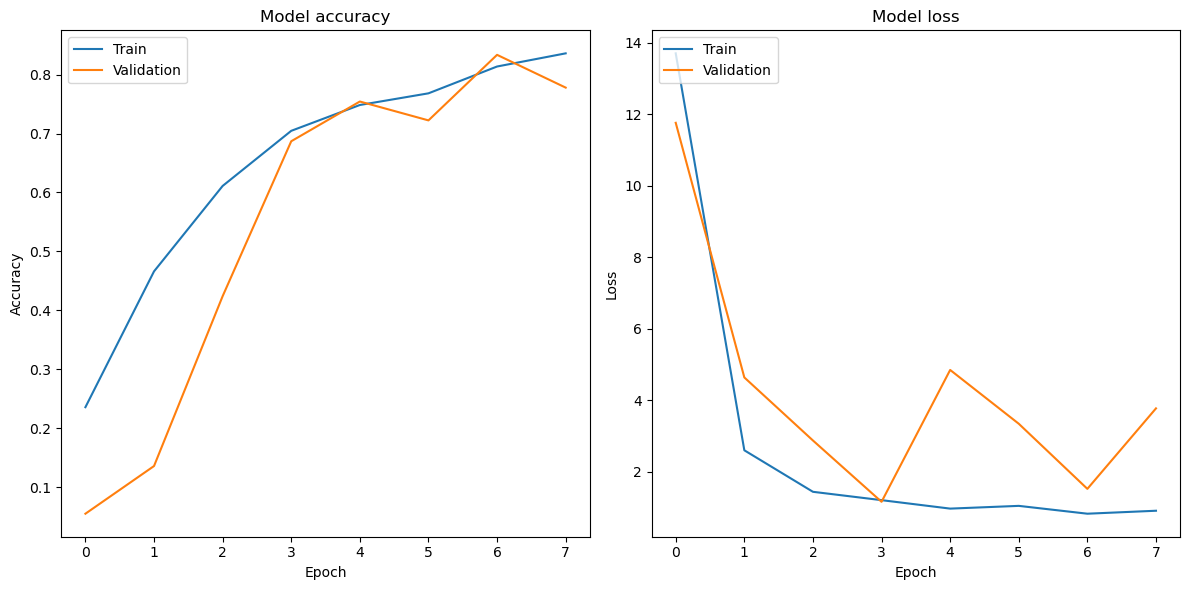

In [216]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# epochs 18

In [217]:
train_loss, train_acc= base_resnet_model.evaluate(train_data)
print('Train accuracy:', train_acc)

75/75 [==============================] - 3s 33ms/step - loss: 2.1191 - accuracy: 0.7980
Train accuracy: 0.7979797720909119


In [218]:
val_loss, val_acc= base_resnet_model.evaluate(val_data)
print('Test accuracy:', val_acc)

19/19 [==============================] - 1s 33ms/step - loss: 3.7774 - accuracy: 0.7778
Test accuracy: 0.7777777910232544


In [185]:
base_resnet_model.save('../../model/my_files/top_up_ResNet.h5')

## Appendix

### Extracting weights

In [17]:
final_resnet = load_model('../../model/my_files/top_up_ResNet.h5')

In [18]:
resnet_layers = final_resnet.layers[0].layers

In [19]:
conv_layer_names = []
for layer in resnet_layers:
    if isinstance(layer,Conv2D) and '_conv' in layer.name:
        conv_layer_names.append(layer.name)

In [79]:
layer = final_resnet.layers[0].get_layer('conv2_block2_3_conv')
weights, baises = layer.get_weights()

In [80]:
weights.shape

(1, 1, 64, 256)

In [37]:
weights

array([[[[-0.00762277,  0.01974086,  0.00640003, ..., -0.00217354,
          -0.01320655, -0.00281542],
         [-0.05648047,  0.01033877,  0.00658092, ...,  0.00386438,
           0.00892565, -0.02711327],
         [ 0.00217434, -0.0243905 ,  0.01304093, ...,  0.02144116,
          -0.0150109 , -0.01485582],
         ...,
         [ 0.0023455 ,  0.02906546, -0.0079094 , ..., -0.01266381,
           0.00587641,  0.04123084],
         [-0.00990357, -0.00096607,  0.00769609, ..., -0.00316527,
           0.01769887,  0.00464331],
         [-0.03140153, -0.02182517,  0.00171724, ...,  0.01414781,
          -0.02693244, -0.00328449]]]], dtype=float32)

In [22]:
conv_model = keras.Model(inputs= final_resnet.layers[0].input, outputs = final_resnet.layers[0].get_layer('conv2_block2_3_conv').output)
conv_model

In [23]:
final_resnet.layers[0].input

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_5')>

In [24]:

X.shape

(34627, 28, 28)

In [35]:
final_resnet.layers[0]


In [36]:
final_resnet.layers[0].get_layer('conv2_block2_3_conv').weight()

AttributeError: 'Conv2D' object has no attribute 'weight'

In [65]:
def inspect_weights(model, layer_name):
  '''
    Overview:
    To get weights from a given layer.

    Arguments:
        - model: CNN model to inspect
        - layer_name: name of layer to access weights

    Output:
        - kernels (weights) as a 3x3 image
  '''

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)


  layer = conv_model.get_layer(layer_name)
  weights, baises = layer.get_weights()

  num_filters = weights.shape[-1]
  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))

  for i, ax in enumerate(axes.flatten()):
      if i < num_filters:
          ax.imshow(weights[:, :, 0, i], cmap='gray')
          ax.set_title(f'Filter {i+1}', fontsize=20)
          ax.set_xticks([])
          ax.set_yticks([])
      else:
          fig.delaxes(ax)  # Delete unused subplots

  plt.show()

In [54]:
conv_layer_names

['conv1_conv',
 'conv2_block1_1_conv',
 'conv2_block1_2_conv',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block2_1_conv',
 'conv2_block2_2_conv',
 'conv2_block2_3_conv',
 'conv2_block3_1_conv',
 'conv2_block3_2_conv',
 'conv2_block3_3_conv',
 'conv3_block1_1_conv',
 'conv3_block1_2_conv',
 'conv3_block1_0_conv',
 'conv3_block1_3_conv',
 'conv3_block2_1_conv',
 'conv3_block2_2_conv',
 'conv3_block2_3_conv',
 'conv3_block3_1_conv',
 'conv3_block3_2_conv',
 'conv3_block3_3_conv',
 'conv3_block4_1_conv',
 'conv3_block4_2_conv',
 'conv3_block4_3_conv',
 'conv4_block1_1_conv',
 'conv4_block1_2_conv',
 'conv4_block1_0_conv',
 'conv4_block1_3_conv',
 'conv4_block2_1_conv',
 'conv4_block2_2_conv',
 'conv4_block2_3_conv',
 'conv4_block3_1_conv',
 'conv4_block3_2_conv',
 'conv4_block3_3_conv',
 'conv4_block4_1_conv',
 'conv4_block4_2_conv',
 'conv4_block4_3_conv',
 'conv4_block5_1_conv',
 'conv4_block5_2_conv',
 'conv4_block5_3_conv',
 'conv4_block6_1_conv',
 'conv4_block6_2_conv',
 

In [73]:
final_resnet.layers

In [75]:
layer = final_resnet.layers[0].get_layer('conv2_block2_2_conv')
weights = layer.get_weights()

In [77]:
weights

[array([[[[-8.69574118e-03,  4.97168070e-03,  8.52445792e-03, ...,
            1.96094587e-02,  4.66071628e-02,  1.22911548e-02],
          [-1.65391732e-02, -4.73848823e-03, -3.17579578e-03, ...,
            5.84223424e-04,  6.60709944e-03, -9.09398682e-03],
          [-8.95634294e-03, -5.80509542e-04,  1.41291870e-02, ...,
           -5.85342804e-03,  3.27499886e-03,  2.47110613e-02],
          ...,
          [ 2.67380127e-03,  1.43503230e-02,  4.60046018e-03, ...,
            3.80990794e-03,  8.74318276e-03,  3.65724578e-03],
          [-4.08237707e-03,  1.66892763e-02, -2.76196655e-03, ...,
           -7.08213355e-03, -2.29736194e-02, -1.05417501e-02],
          [-1.08638266e-02,  2.02057026e-02, -3.12679932e-02, ...,
           -4.33131121e-03, -9.63528547e-03,  8.89494084e-03]],
 
         [[ 6.48283772e-03,  5.65535016e-03,  3.79172526e-03, ...,
            3.70953158e-02,  2.00501643e-02, -1.12160910e-02],
          [-2.96145398e-03,  1.27946399e-03,  3.29397371e-05, ...,
     

In [78]:
plt.imshow(weights[:, :, 0, 1], cmap='gray')

TypeError: list indices must be integers or slices, not tuple

In [67]:
inspect_weights(final_resnet.layers[0],'conv2_block1_1_conv')

ValueError: not enough values to unpack (expected 2, got 1)

### Extract feature maps

2024-07-03 14:36:34.318477: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 311ms/step


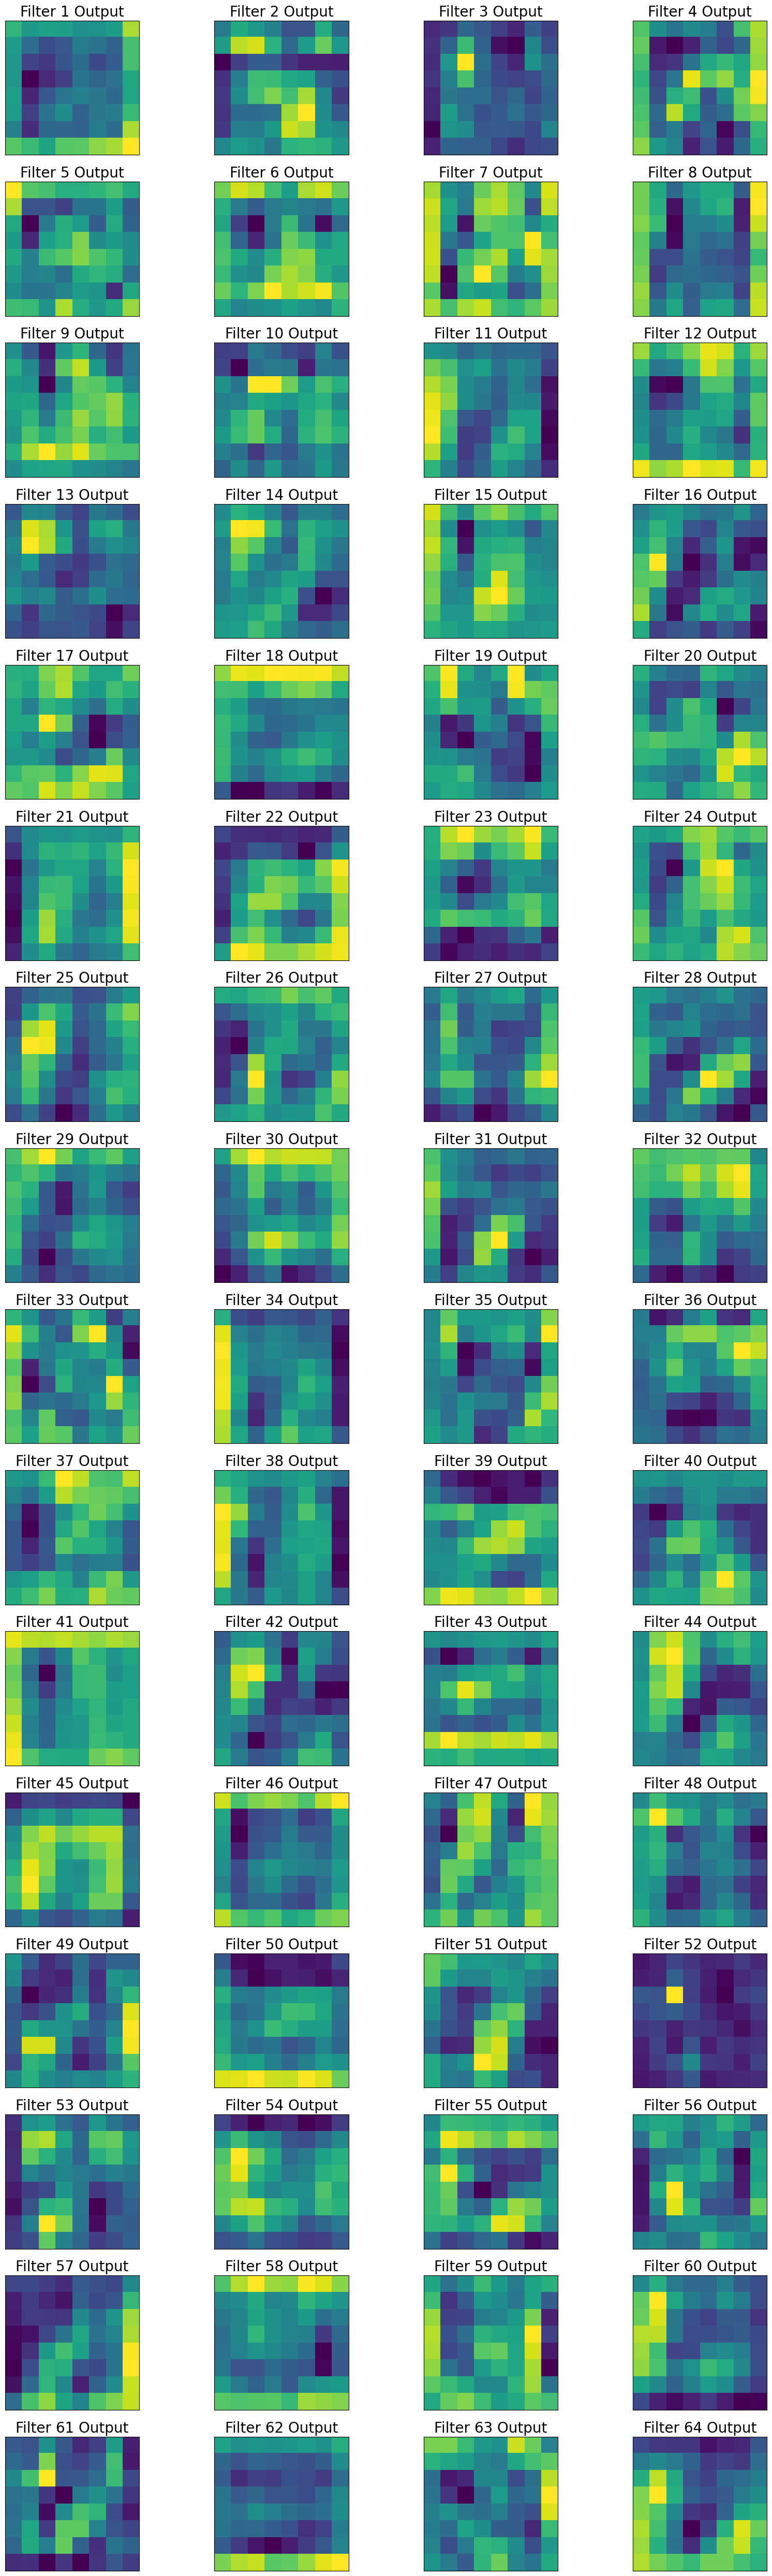

In [64]:
get_conv_layer_ouput(model = final_resnet.layers[0], layer_name = 'conv2_block2_2_conv', input_img = get_letter_img('a') )

In [179]:
conv_model = keras.Model(inputs= final_resnet.layers[0].input, outputs = final_resnet.layers[0].get_layer('conv2_block2_3_conv').output)

# Appendix

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [69]:
def create_model(learning_rate=0.001):
	model = load_model('../../model/my_files/my_ResNet_model.h5')
	optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
	my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimiser,
                  metrics = ['accuracy'])
	

	return model

In [70]:
# Define hyperparameters to search
param_grid = {
    'learning_rate': [0.001, 0.0001, 0.0005, 0.00001],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}


In [71]:
model = load_model('../../model/my_files/my_ResNet_model.h5')
model = KerasClassifier(build_fn=create_model, verbose=0)

/var/folders/m1/502kn7jx4nd1sm29zp721mh40000gn/T/ipykernel_50058/804499668.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [72]:
# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3, verbose=2)
random_search_result = random_search.fit(X_train_resized, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 9234,  9235,  9236, ..., 27698, 27699, 27700])